# Bayesian Seizure Likelihood Estimation

In [1]:
import gpytorch
import pyro
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import torch
import tqdm
import zarr

from msc.data_utils import get_dataset, get_sample_rate_from_ds, get_config_dataset, get_sample_times, get_event_sample_times
from msc.plot_utils import plot_sample, set_size
from msc.prior_utils import get_events_df, vm_density, vm_mixture
from msc.time_utils import uSEC, SEC
from msc import config

plt.style.reload_library()

plt.style.use(['science', 'no-latex'])
plt.rcParams.update(
    {
    "legend.facecolor": "white",
    # "font.family": "serif",   # specify font family here
    # "font.serif": ["Times"],  # specify font here
    # "font.size":11
    }
    )          # specify font size here
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.gri

## Sample space

* eeg plot example
* seizure sequence plot example

In [3]:

ds = get_config_dataset()

In [4]:
cache_zarr = zarr.open(f"{config['path']['data_v1']}/cache.zarr")
ds_zarr = cache_zarr[config['dataset_id']]

In [5]:
if False:
    # use this to see event history
    print(ds.get_annotations('seizures'))

In [6]:
mean = ds_zarr['mu']
std = ds_zarr['std']

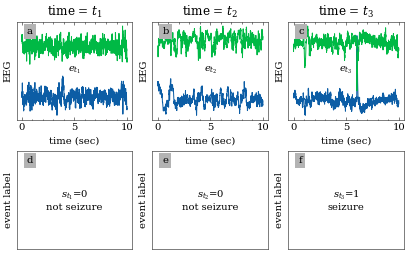

In [7]:
fig, axs = plt.subplot_mosaic([['a', 'b', 'c'], ['d', 'e', 'f']], constrained_layout=True, figsize=set_size(409))

sfreq = get_sample_rate_from_ds(ds)
sample_times = [300000, 3000000, 1247349926757/1e6]

for label, ax in axs.items():
    if label == 'a':
        sample = ds.get_data(sample_times[0], 10, np.arange(2))
        sample = (sample - np.mean(sample, axis=0)) / np.std(sample, axis=0)
        plot_sample(np.arange(sample.shape[0]) / sfreq, sample, ax=ax)
        ax.annotate("$e_{t_1}$", xy=(0.5, 0.5), xytext=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        ax.set_title('time = $t_1$')

    elif label == 'b':
        sample = ds.get_data(sample_times[1], 10, np.arange(2))
        sample = (sample - np.mean(sample, axis=0)) / np.std(sample, axis=0)
        plot_sample(np.arange(sample.shape[0]) / sfreq, sample, ax=ax)
        ax.annotate("$e_{t_2}$", xy=(0.5, 0.5), xytext=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        ax.set_title('time = $t_2$')
        
    elif label == 'c':
        sample = ds.get_data(sample_times[2], 10, np.arange(2))
        sample = (sample - np.mean(sample, axis=0)) / np.std(sample, axis=0)
        plot_sample(np.arange(sample.shape[0]) / sfreq, sample, ax=ax)
        ax.annotate("$e_{t_3}$", xy=(0.5, 0.5), xytext=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        ax.set_title('time = $t_3$')


    elif label == 'd':
        ax.annotate("$s_{t_1}$=0\nnot seizure", xy=(0.5, 0.5), xytext=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        # ax.set_xlabel("$s_t$")
        ax.set_ylabel("event label")
        ax.set_xticks([])
        ax.set_yticks([])
        

    elif label == 'e':
        ax.annotate("$s_{t_2}$=0\nnot seizure", xy=(0.5, 0.5), xytext=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        # ax.set_xlabel("$s_t$")
        ax.set_ylabel("event label")
        ax.set_xticks([])
        ax.set_yticks([])

    elif label == 'f':
        ax.annotate("$s_{t_3}$=1\nseizure", xy=(0.5, 0.5), xytext=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        # ax.set_xlabel("$s_t$")
        ax.set_ylabel("event label")
        ax.set_xticks([])
        ax.set_yticks([])

    else:
        ax.annotate("hello", xy=(0, 0))

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

plt.savefig(f"{config['path']['figures']}/bsle_intro/sample_space.pdf", bbox_inches='tight')

## circular Gaussian mixture distribution

Forward-simulation of circular Gaussian distribution

Text(0.5, 0, 'time')

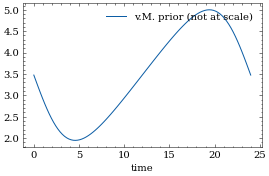

In [8]:
fig = plt.figure(figsize=set_size(309))

weights = np.arange(24)
X = np.linspace(0, 24, 100)
y = vm_mixture(X, weights)
y = 5 * y / max(y)  # TODO: make this same height as bar chart
plt.plot(X, y, label="v.M. prior (not at scale)")
legend = plt.legend(loc="upper right", framealpha=1)
# TODO: fix facecolor to white
frame = legend.get_frame()
frame.set_facecolor("white")
plt.xlabel("time")
# plt.title("")

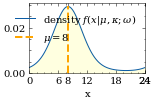

In [9]:
def plot_vmdensity(width, N=24, mu=8, k=1 / 0.6):
    X = np.linspace(0, N, 100)
    y = vm_density(X, mu=mu, k=k)

    # prepare figure
    fig = plt.figure(figsize=set_size(width))
    plt.plot(X, y, label="density $f(x | \mu, \kappa ; \omega)$")
    plt.fill_between(X, y, color="lightyellow")
    plt.vlines(
        [mu], 0, max(y), linestyles="dashed", colors="orange", lw=2, label=f"$\mu={mu}$"
    )
    plt.xlabel("x")
    extraticks = [mu, N]
    plt.xticks([0, 6, 12, 18, 24] + extraticks)
    plt.xlim(0, N)
    plt.ylim(bottom=0)
    plt.legend()

plot_vmdensity(150)

# plt.savefig(f"{config['path']['figures']}/bsle_intro/vm_density.pdf", bbox_inches="tight")

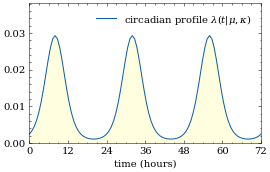

In [10]:
def plot_long_vmdensity(width, N=24, mu=8, k=1 / 0.6, repeat=3):
    X = np.linspace(0, repeat * N, 100)
    y = vm_density(X, mu=mu, k=k)

    # prepare figure
    fig = plt.figure(figsize=set_size(width))
    plt.plot(X, y, label="circadian profile $\lambda(t | \mu, \kappa)$")
    plt.fill_between(X, y, color="lightyellow")

    plt.xlabel("time (hours)")
    plt.xticks([0, 12, 24, 36, 48, 60, 72])
    plt.xlim(0, repeat * N)
    plt.ylim(bottom=0, top=max(y) * 1.3)
    legend = plt.legend(loc='upper right', facecolor='white', framealpha=1)
    frame = legend.get_frame()
    frame.set_facecolor("white")
    frame.set_edgecolor("white")

plot_long_vmdensity(300)

plt.savefig(f"{config['path']['figures']}/bsle_intro/long_vmdensity.pdf", bbox_inches="tight")

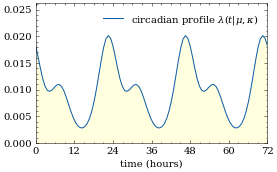

In [11]:
def plot_circadian_profile(width, N=24, repeat=3):
    X = np.linspace(0, repeat * N, 100)
    # # y = vm_density(X, mu=mu, k=k)
    # weights = [1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    weights = np.zeros(N)
    weights[7] = 4
    weights[22] = 8
    # values = [7, 23]
    # weights = np.sum(np.eye(N)[values], axis=0)
    # weights =  np.random.uniform(0, 1, 24)
    y = vm_mixture(X, weights)

    # prepare figure
    fig = plt.figure(figsize=set_size(width))
    plt.plot(X, y, label="circadian profile $\lambda(t | \mu, \kappa)$")
    plt.fill_between(X, y, color="lightyellow")

    plt.xlabel("time (hours)")
    plt.xticks([0, 12, 24, 36, 48, 60, 72])
    plt.xlim(0, repeat * N)
    plt.ylim(bottom=0, top=max(y) * 1.3)
    legend = plt.legend(loc='upper right', facecolor='white', framealpha=1)
    frame = legend.get_frame()
    frame.set_facecolor("white")
    frame.set_edgecolor("white")

plot_circadian_profile(300)

plt.savefig(f"{config['path']['figures']}/bsle_intro/circadian_profile.pdf", bbox_inches="tight")

## Sample from prior intensity

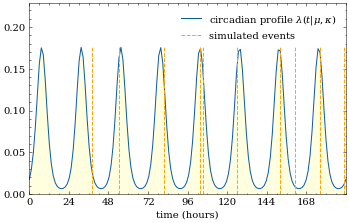

In [12]:
def plot_circadian_profile_with_events(width, N=24, repeat=8):
    max_time = repeat*N
    X = np.linspace(0, max_time, 160)
    # # y = vm_density(X, mu=mu, k=k)
    # weights = [1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    weights = np.zeros(N)
    weights[7] = 4
    weights[22] = 0
    # values = [7, 23]
    # weights = np.sum(np.eye(N)[values], axis=0)
    # weights =  np.random.uniform(0, 1, 24)
    # y = vm_mixture(X, weights)
    intensity_function = lambda x : 6 * vm_mixture(x, weights)
    y = intensity_function(X)
    # sample from the distribution

    num_samples = int(pyro.distributions.Poisson(y.mean() * max_time).sample().item())

    def log_prob_accept(val):
        intensities = intensity_function(val)
        res = torch.log(intensities / (y.mean() * max_time))
        return res

    arrival_times = pyro.distributions.Rejector(
        propose=pyro.distributions.Uniform(X.min(), X.max()),
        log_prob_accept=log_prob_accept,
        log_scale=0.
    )(torch.Size([num_samples]))

    # prepare figure
    fig = plt.figure(figsize=set_size(width))
    plt.plot(X, y, label="circadian profile $\lambda(t | \mu, \kappa)$")
    plt.fill_between(X, y, color="lightyellow")

    plt.xlabel("time (hours)")
    plt.xticks(np.arange(0, max_time, 24))
    plt.xlim(0, repeat * N)
    plt.ylim(bottom=0, top=max(y) * 1.3)
    plt.vlines(arrival_times, 0, max(y), linestyles="--", colors="orange", lw=1, label=f"simulated events")
    legend = plt.legend(loc='upper right', facecolor='white', framealpha=1)
    frame = legend.get_frame()
    frame.set_facecolor("white")
    frame.set_edgecolor("white")
    return arrival_times


arrival_times = plot_circadian_profile_with_events(410)

plt.savefig(f"{config['path']['figures']}/bsle_intro/circadian_profile_with_events.pdf", bbox_inches="tight")

In [13]:
arrival_times = torch.arange(0, 24*8, 24)

In [14]:
arrival_times

tensor([  0,  24,  48,  72,  96, 120, 144, 168])

## Build the inference engine

In [15]:
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_arrivals, max_time, num_inducing=32, name_prefix="cox_gp_model", kernel: str="v1"):
        self.name_prefix = name_prefix
        self.max_time = max_time
        self.mean_intensity = (num_arrivals / max_time)

        # Define the variational distribution and strategy of the GP
        # We will initialize the inducing points to lie on a grid from 0 to T
        inducing_points = torch.linspace(0, max_time, num_inducing).unsqueeze(-1)
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(num_inducing_points=num_inducing)
        variational_strategy = gpytorch.variational.VariationalStrategy(self, inducing_points, variational_distribution)

        # Define model
        super().__init__(variational_strategy=variational_strategy)

        # Define mean and kernel
        self.mean_module = gpytorch.means.ZeroMean()
        if kernel == "v1":
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        elif kernel == "v2":
            # period_length_prior=gpytorch.priors.NormalPrior(50, 10)
            # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.CosineKernel(period_length_prior))
            # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.CosineKernel())
            self.covar_module = gpytorch.kernels.CosineKernel(period_length_constraint=gpytorch.constraints.Interval(22,26))
        elif kernel == "v3":
            self.covar_module = gpytorch.kernels.PeriodicKernel()
        elif kernel == "v4":
            self.covar_module = gpytorch.kernels.RBFKernel() * gpytorch.kernels.PeriodicKernel()
        else:
            raise ValueError(f"Unknown kernel {kernel}")

    def forward(self, times):
        mean = self.mean_module(times)
        covar = self.covar_module(times)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    def guide(self, arrival_times, quadrature_times):
        function_distribution = self.pyro_guide(torch.cat([arrival_times, quadrature_times], -1))

        # Draw samples from q(f) at arrival_times
        # Also draw samples from q(f) at evenly-spaced points (quadrature_times)
        with pyro.plate(self.name_prefix + ".times_plate", dim=-1):
            pyro.sample(
                self.name_prefix + ".function_samples",
                function_distribution
            )

    def model(self, arrival_times, quadrature_times):
        pyro.module(self.name_prefix + ".gp", self)
        function_distribution = self.pyro_model(torch.cat([arrival_times, quadrature_times], -1))

        # Draw samples from p(f) at arrival times
        # Also draw samples from p(f) at evenly-spaced points (quadrature_times)
        with pyro.plate(self.name_prefix + ".times_plate", dim=-1):
            function_samples = pyro.sample(
                self.name_prefix + ".function_samples",
                function_distribution
            )

        ####
        # Convert function samples into intensity samples, using the function above
        ####
        intensity_samples = function_samples.exp() * self.mean_intensity

        # Divide the intensity samples into arrival_intensity_samples and quadrature_intensity_samples
        arrival_intensity_samples, quadrature_intensity_samples = intensity_samples.split([
            arrival_times.size(-1), quadrature_times.size(-1)
        ], dim=-1)

        ####
        # Compute the log_likelihood, using the method described above
        ####
        arrival_log_intensities = arrival_intensity_samples.log().sum(dim=-1)
        est_num_arrivals = quadrature_intensity_samples.mean(dim=-1).mul(self.max_time)
        log_likelihood = arrival_log_intensities - est_num_arrivals
        pyro.factor(self.name_prefix + ".log_likelihood", log_likelihood)

In [16]:
# Here's a quick helper function for getting smoothed percentile values from samples
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples


In [17]:
def plot_inference_intensity(arrival_times, kernel:str, N=24, repeat=8, width=410):
    from pyro.optim import StepLR
    # from pyro.optim import ExponentialLR

    max_time = N * repeat
    model = GPModel(arrival_times.numel(), max_time, kernel=kernel)
    quadrature_times = torch.linspace(0, max_time, 128)
    pyro.clear_param_store()  # so that notebook supports repeated runs
    num_iter = 400
    num_particles = 64

    lr = 0.1
    optimizer = torch.optim.Adam
    scheduler = StepLR({"optimizer": optimizer, "step_size": 30, "gamma": 0.1, "optim_args": {"lr": lr}})
    # scheduler = ExponentialLR({"optimizer": optimizer, "gamma" : 0.1, "optim_args": {"lr": lr}})

    loss = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
    infer = pyro.infer.SVI(model.model, model.guide, scheduler, loss=loss)

    model.train()
    loader = tqdm.notebook.tqdm(range(num_iter))
    lr_curr = None
    
    for i in loader:
        loss = infer.step(arrival_times, quadrature_times)
        lr_curr = next(iter(infer.optim.optim_objs.values()))._last_lr[0]  # get the current LR
        print(f"{lr_curr=}")
        # lr_curr = scheduler.get_last_lr()[0]  # get the current LR
        loader.set_postfix(loss=loss)
        scheduler.step()

    model.eval()

    with torch.no_grad():
        function_dist = model(quadrature_times)
        intensity_samples = function_dist(torch.Size([1000])).exp() * model.mean_intensity
        lower, mean, upper = percentiles_from_samples(intensity_samples)

    weights = np.zeros(N)
    weights[7] = 4
    weights[22] = 0
    intensity_function = lambda x : 6 * vm_mixture(x, weights)
    # Plot the predicted intensity function
    fig, ax = plt.subplots(1, 1, figsize=set_size(width))
    line, = ax.plot(quadrature_times, mean, label=r"Pred $\lambda$")
    ax.fill_between(quadrature_times, lower, upper, color=line.get_color(), alpha=0.5)
    # ax.plot(quadrature_times, intensity_function(quadrature|_times), "--", color="k", label=r"True. $\lambda$")
    ax.legend(loc="best")
    ax.set_xlabel("Time")
    ax.set_ylabel("Intensity ($\lambda$)")
    ax.scatter(arrival_times, torch.zeros_like(arrival_times), label=r"Observed Arrivals")
    return model


  0%|          | 0/400 [00:00<?, ?it/s]

/home/noamsi/.conda/envs/msc/lib/python3.8/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1658220902664/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr

lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=

/home/noamsi/.conda/envs/msc/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/noamsi/.conda/envs/msc/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/noamsi/.conda/envs/msc/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/noamsi/.conda/envs/msc/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1756: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.. Using symeig method.
  warnings.warn(
[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


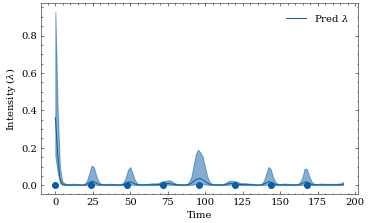

In [18]:
trained_model = plot_inference_intensity(arrival_times, kernel="v4")
plt.savefig(f"{config['path']['figures']}/bsle_intro/inference_of_intensity_v4.pdf", bbox_inches="tight")

  0%|          | 0/400 [00:00<?, ?it/s]

lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr

lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=

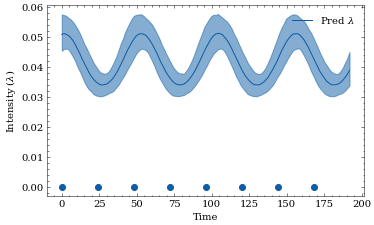

In [19]:
trained_model = plot_inference_intensity(arrival_times, kernel="v2")
plt.savefig(f"{config['path']['figures']}/bsle_intro/inference_of_intensity_v2.pdf", bbox_inches="tight")

In [20]:
trained_model.covar_module.raw_period_length

Parameter containing:
tensor([[2.7128]], requires_grad=True)

In [21]:
trained_model.covar_module.period_length

tensor([[25.7511]], grad_fn=<AddBackward0>)

In [22]:
np.exp(6.1543)

470.7372110555569

In [23]:
for param_name, param in trained_model.covar_module.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param}')

Parameter name: raw_period_length                          value = Parameter containing:
tensor([[2.7128]], requires_grad=True)


  0%|          | 0/400 [00:00<?, ?it/s]

lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1


/home/noamsi/.conda/envs/msc/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_

lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=

/home/noamsi/.conda/envs/msc/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/noamsi/.conda/envs/msc/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/noamsi/.conda/envs/msc/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/noamsi/.conda/envs/msc/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1756: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.. Using symeig method.
  warnings.warn(


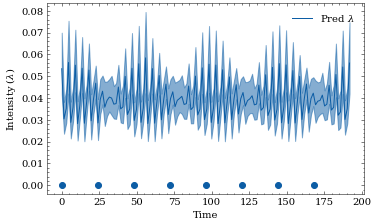

In [24]:
trained_model = plot_inference_intensity(arrival_times, kernel="v3")
plt.savefig(f"{config['path']['figures']}/bsle_intro/inference_of_intensity_v3.pdf", bbox_inches="tight")

/home/noamsi/.conda/envs/msc/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/noamsi/.conda/envs/msc/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/noamsi/.conda/envs/msc/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/noamsi/.conda/envs/msc/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1756: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.. Using symeig method.
  warnings.warn(


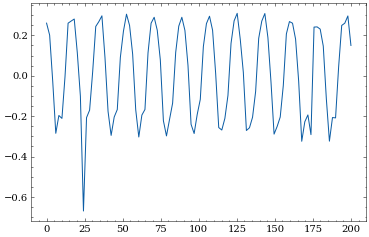

In [25]:
times = torch.linspace(0, 200, 100)
plt.plot(times, trained_model(times).sample())

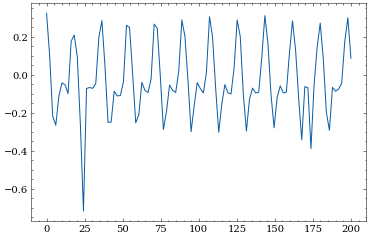

In [26]:
times = torch.linspace(0, 200, 100)
plt.plot(times, trained_model(times).sample())

  0%|          | 0/400 [00:00<?, ?it/s]

lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.1
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr_curr=0.010000000000000002
lr

lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-10
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=1.0000000000000006e-11
lr_curr=

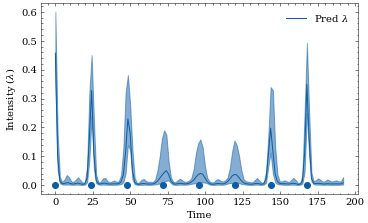

In [27]:
trained_model = plot_inference_intensity(arrival_times, kernel="v1")
plt.savefig(f"{config['path']['figures']}/bsle_intro/inference_of_intensity_v1.pdf", bbox_inches="tight")

In [28]:
for param_name, param in trained_model.covar_module.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param}')

Parameter name: raw_outputscale                            value = 0.10089652240276337
Parameter name: base_kernel.raw_lengthscale                value = Parameter containing:
tensor([[2.4641]], requires_grad=True)


In [29]:
for constraint_name, constraint in trained_model.named_constraints():
    print(f'Constraint name: {constraint_name:55} constraint = {constraint}')


Constraint name: covar_module.raw_outputscale_constraint                 constraint = Positive()
Constraint name: covar_module.base_kernel.raw_lengthscale_constraint     constraint = Positive()


## Run the inference engine

In [30]:
constraint = trained_model.covar_module.base_kernel.raw_period_length_constraint
period_length = constraint.transform(trained_model.covar_module.base_kernel.raw_period_length)

AttributeError: 'RBFKernel' object has no attribute 'raw_period_length_constraint'

In [ ]:
period_length

In [ ]:
np.exp(-1.5791)

In [ ]:
gpytorch.__version__

## Plot the inference engine results

## Empirical events - subject_id

## Plot the inference of the empirical data

## Sampling the Cox Process

## Inferring the Latent Intensity Function

## Checking the Model